# 0. Contents

> 1.Dataset
<br>
>> 1.1. Splitting
<br>
>> 1.2. Train and Test Set Loader
<br>
>> 1.3. Visualization of Images
<br>
>> 1.4. Width and Height
<br>
>> 1.5. RGB Histogram


> 2. Preprocessing
<br>
> 2.1. Resize Performance
<br>
> 2.2. Padding, Resizing, RGB to Greyscale
<br>
> 2.3. PCA Basics
<br>
> 2.4. Flattening
<br>
> 2.5. PCA Feature Reduction

> 3. Machine Learning Models
<br>
> 3.1. Logistic Regression
<br>
> 3.2. Random Forest
<br>
> 3.3. Gradiant Boosting
<br> 
> 3.4. Support Vector Machine
<br>
> 3.5. Convolutional Neural Network

> 4. Evaluation
<br>
> 4.1 Accuracy
<br>
> 4.2 Confusion Matrix
<br>
> 4.3 Precision
<br>
> 4.4 Recall
<br>
> 4.5 Discussion
<br>
> 4.6 Re-evaluation image size

# 1. Dataset

This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/. The dataset contains two folders with each 13779 images (27558 images in total). The images shows microscopic bloodcells which are either uninfected and healthy or parasitized and infected with malaria.

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

## 1.1. Splitting

This function will load all images from both folders and split the set into training-set, testing-set and validation-set. The partition ratio is set to 80/20 due to the large image set. For reproduction purpose, we will save the partition in csv tables and call them each time, when needed. It is also necessary to impose numbered labels for each set: Uninfected cell images will have the label 0 and Parasitized label 1.

In [43]:
# splitting ratio eg. split_ratio=80 for 80% training set and 20% testset
def dataset_split(split_ratio, img_dir):
    
    label = 0
    list_test = []
    list_val = []
    list_train = []
    for folder in folders:
        # get all filenames
        fnames = [os.path.basename(x) for x in glob.glob(os.path.join(img_dir,folder,'*.png'))]

        # splitting ratio
        test_split = round(len(fnames)*(100-split_ratio)/100)

        # shuffle filenames
        np.random.seed(0)
        np.random.shuffle(fnames)
    
        # save list of test image-filenames
        fn_test = fnames[:test_split]
        lb_test = np.full(len(fn_test),label,dtype=np.int)
        list_test.extend(list(zip(fn_test, lb_test)))

        # save list of training image-filenames
        fn_train = fnames[test_split:]
        lb_train = np.full(len(fn_train),label,dtype=np.int)
        list_train.extend(list(zip(fn_train, lb_train)))

        label+=1
    
    
    # save both sets as csv
    # filename, label
    df_test = pd.DataFrame(list_test)
    df_train = pd.DataFrame(list_train)
    df_test.to_csv('test.csv', index=False, header=False)
    df_train.to_csv('train.csv', index=False, header=False)
    

Call this function to split the images in both folders of img_dir into training and testing set. The splitting result is saved in train.csv and test.csv.

In [ ]:
img_dir = 'C:\\Users\\giang-chau\\Desktop\\Machine Learning\\Projektbeschreibungen\\cell_images'
# execute splitting
# split img data for each label     
dataset_split(80, img_dir)

## 1.2. Train and Testset Loader

The function get_datasets will load images into a list of arrays and the respective label-data in the same order, as it is stated in the csv table. Make sure you pick the right folder and csv-file in your path. This function is used for our machine learning models. The images will be normalized and the image counts in each folder will be printed.

In [2]:
def get_datasets(img_path, csvfile, folders):
    
    x = []
    y = []
    
    # read csv table, get filenames and label
    data = pd.read_csv(csvfile, header=None)
    filenames = data.iloc[:, 0].tolist()
    labels = data.iloc[:, 1].tolist()
    
    # load images and labels as sets
    for fn,lb in zip(filenames,labels):
        img = Image.open(os.path.join(img_path,folders[lb],fn))          
        img = np.array(img) / 255.
        # to greyscale
        # img = img.convert('L')
        x.append(img)
        y.append(lb)
        
    
    print(folders[0]+':'+str(y.count(0)))
    print(folders[1]+':'+str(y.count(1)))
    
    return x, y

Load train and test set.

In [48]:
img_dir = 'C:\\Users\\giang-chau\\Desktop\\Machine Learning\\Projektbeschreibungen\\cell_images'
folders = ['Uninfected', 'Parasitized']
csv_train = 'train.csv'
csv_test = 'test.csv'

print('load train data')
x_train, y_train = get_datasets(img_dir, csv_train, folders)
print('load test data')
x_test, y_test = get_datasets(img_dir, csv_test, folders)

load train data
Uninfected:11023
Parasitized:11023
load test data
Uninfected:2756
Parasitized:2756


## 1.3. Visualization of Images

The uninfected and parasitized cell images are png-files with different sizes and width/height ratios. The cells are sourrounded by black pixels and the cells have different shapes. The colors in the uninfected cell images are more uniform than the colors of the parasitized cell images. The parasitized cell images seems to contain contour patterns of the parasites. The main task of the classification model will be to detect these differences automatically.

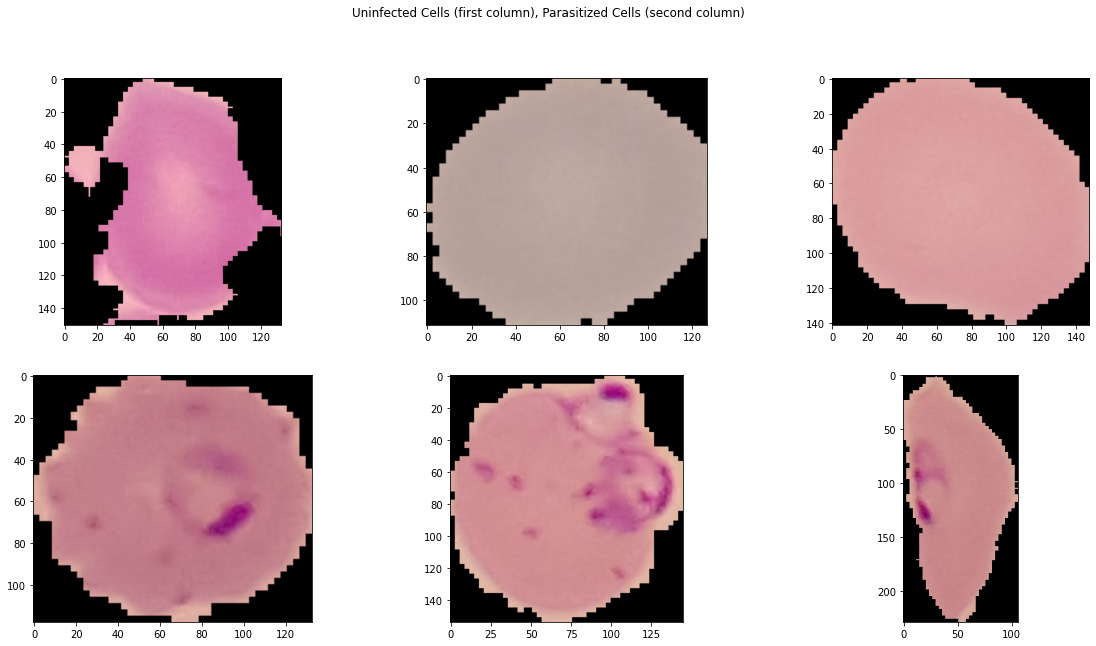

In [49]:
f, axs = plt.subplots(2,3)
f.suptitle('Uninfected Cells (first column), Parasitized Cells (second column)')
axs[0,0].imshow(x_train[0])
axs[0,1].imshow(x_train[1])
axs[0,2].imshow(x_train[2])
axs[1,0].imshow(x_train[9000])
axs[1,1].imshow(x_train[9153])
axs[1,2].imshow(x_train[9032])
f.set_size_inches(20,10)
plt.show()

## 1.4. Width and Height

To choose an uniform size for each image, we will look at the distribution for image widths and height. The average width and height is ~133 px. It possible to use 133x133 px sized images for further usage, but the modelling can be computational expensive. To investigate if downsizing the images can infect the cassification, we will test the performance of different image sizes.

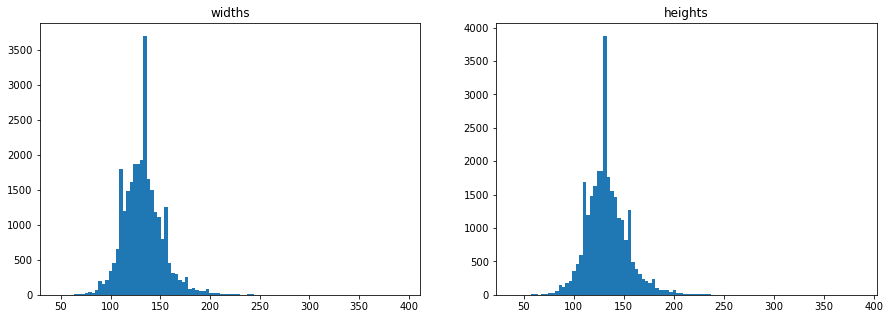

In [50]:
# get width and height from all images
widths = []
heights = []
for xtn in x_train:
    h, w, c = np.shape(xtn)
    widths.append(w)
    heights.append(h)
    
for xtt in x_test:
    h, w, c = np.shape(xtt)
    widths.append(w)
    heights.append(h)
    
# plot distribution of image width and height as histograms
f, axs = plt.subplots(1,2)
axs[0].hist(widths, bins = 100)
axs[0].set_title('widths')
axs[1].hist(heights, bins = 100)
axs[1].set_title('heights')
f.set_size_inches(15,5)
plt.show()

The average image width and height.

In [51]:
print('average width:')
print(np.mean(widths))

print('average height:')
print(np.mean(heights))

average width:
132.48715436533857
average height:
132.9834530807751


## 1.5. RGB Histogram

Considering the color channels contributes each to the classification feature describtion, we will look at an example image. In this case, we have an image of an uninfected cell and the respective color histogram. The histogram doesn't show the black pixel counts.
<br>
The black pixels in the images doesn't contribute to the classification if the cell image is uninfected or not. This fact can be considered beforehand and could be cancelled before model training to reduce feature dimension. But we will test the case, if a model is capable to process this information.

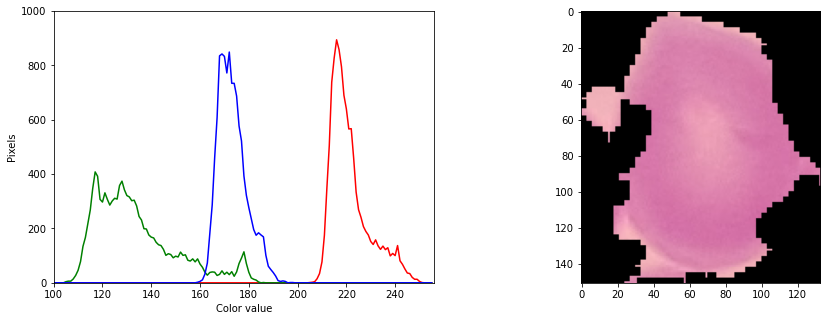

In [52]:
# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
im = x_train[0]*255.
f, axs = plt.subplots(1,2)
axs[0].set_xlim([100, 256])
axs[0].set_ylim([0, 1000])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        im[:, :, channel_id], bins=256, range=(0, 256)
    )
    axs[0].plot(bin_edges[0:-1], histogram, color=c)

axs[0].set_xlabel("Color value")
axs[0].set_ylabel("Pixels")

axs[1].imshow(x_train[0])
f.set_size_inches(15,5)

plt.show()

In the image above we can see, that the blue and red color channel peaks in brighter range than the green channel. To check the color channel pixel distribution we will visualize the color histogram of both labels for all images.

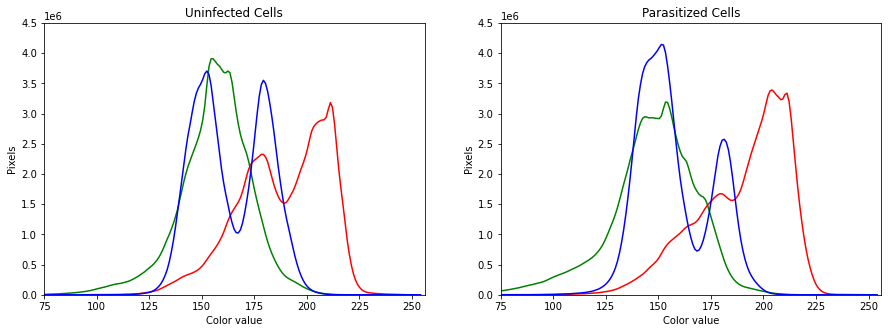

In [54]:
# plot histograms for each label in training set
img_dir = 'C:\\Users\\giang-chau\\Desktop\\Machine Learning\\Projektbeschreibungen\\cell_images'
folders = ['Uninfected', 'Parasitized']
csv_files = ['train.csv', 'test.csv']

nb_bins = 256
un_count_r = np.zeros(nb_bins)
un_count_g = np.zeros(nb_bins)
un_count_b = np.zeros(nb_bins)
par_count_r = np.zeros(nb_bins)
par_count_g = np.zeros(nb_bins)
par_count_b = np.zeros(nb_bins)

# read csv table, get filename and label
data = pd.read_csv(csv_files[0], header=None)
filenames = data.iloc[:, 0].tolist()
labels = data.iloc[:, 1].tolist()

#
for fn,lb in zip(filenames,labels):
    img = np.asarray(Image.open(os.path.join(img_dir,folders[lb],fn)))
    hist_r = np.histogram(img[:,:,0], bins=nb_bins, range=[0, 255])
    hist_g = np.histogram(img[:,:,1], bins=nb_bins, range=[0, 255])
    hist_b = np.histogram(img[:,:,2], bins=nb_bins, range=[0, 255])
    if lb == 0:
        un_count_r += hist_r[0]
        un_count_g += hist_g[0]
        un_count_b += hist_b[0]
        
    if lb == 1:
        par_count_r += hist_r[0]
        par_count_g += hist_g[0]
        par_count_b += hist_b[0]


bins = hist_r[1]

f, axs = plt.subplots(1,2)

axs[0].plot(bins[:-1], un_count_r, color='r')
axs[0].plot(bins[:-1], un_count_g, color='g')
axs[0].plot(bins[:-1], un_count_b, color='b')
axs[0].set_ylim([0, 4.5E6])
axs[0].set_xlim([75, 256])
axs[0].set_xlabel("Color value")
axs[0].set_ylabel("Pixels")
axs[0].set_title('Uninfected Cells')

axs[1].plot(bins[:-1], par_count_r, color='r')
axs[1].plot(bins[:-1], par_count_g, color='g')
axs[1].plot(bins[:-1], par_count_b, color='b')
axs[1].set_ylim([0, 4.5E6])
axs[1].set_xlim([75, 256])
axs[1].set_xlabel("Color value")
axs[1].set_ylabel("Pixels")
axs[1].set_title('Parasitized Cells')

f.set_size_inches(15,5)
plt.show()

In the above color histograms the black pixels are cut off, because the amount is very large. The distribution of the red, blue and green pixels are almost in the same range. The amount of blue pixels peaks very high in the parasitized cell images compared to the images of the uninfected cells. In this case it is possible to filter colored features in the images. But still, we want to investigate if the classification model will distinguish this.

# 2. Preprocessing

![Preprocessing](Preprocessing.png)

To stream the images in uniform sizes into the model and to reduce computational time the images will be preprocessed before model training. Following images will be used and generated:

Image Paths
<br>
<br>
size 50x50 px, grey, padded:
<br>
.../cell_images/dz50_pad_bw_Parasitized
<br>
.../cell_images/dz50_pad_bw_Uninfected
<br>
<br>
size 50x50 px, rgb, padded:
<br>
.../cell_images/dz50_pad_Parasitized
<br>
.../cell_images/dz50_pad_Uninfected
<br>
<br>
size 133x133 px, rgb, padded:
<br>
.../cell_images/pad_Parasitized
<br>
.../cell_images/pad_Uninfected
<br>
<br>
original:
<br>
.../cell_images/Parasitized
<br>
.../cell_images/Uninfected

## 2.1. Resize Performance

As shown before, the images vary a lot in size. Initially we started with images resized to the mean of occurring sizes. Due to hardware constraints, we decided to take a closer look at how image size influences the accuracy of two baseline estimators. The results are supposed to enable us to judge, which image size is feasable, as in low runtime, while still maintaining an acceptable accuracy.

For this study only a partial dataset was used to keep the runtime down.

In [61]:
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [1]:
import glob
import os
import numpy as np
import pandas as pd
from PIL import Image

In [4]:
# define image folders
img_dir = '.../cell_images'
folders = ['pad_Uninfected', 'pad_Parasitized']
csv_files = ['train.csv', 'test.csv']

# define a function to load a partial dataset with variing sizes

def get_small_dataset_var_sizes(img_path, csvfile, sizes, number=100):
    
    s = sizes
    n = int(number/2)
    x = []
    y = []
    xs = []
    ys = []
    # read csv table
    data = pd.read_csv(csvfile, header=None)
    # sort data by labels to separate infected from uninfected to ensure an even split
    data.sort_values(by=1)
    # extract a specified number of values from each class
    data0 = data.iloc[:n, :]
    data1 = data.iloc[-n:, :]
    data = data0.append(data1)
    # shuffle the classes
    data = data.sample(frac=1).reset_index(drop=True)
    
    # get filename and label
    filenames = data.iloc[:, 0].tolist()
    labels = data.iloc[:, 1].tolist()
    
    # load images with conversion to b/w
    for fn,lb in zip(filenames,labels):
        img = Image.open(os.path.join(img_path,folders[lb],fn))
        img = img.convert("L")
        img = np.array(img) / 255.
        x.append(img)
        y.append(lb)
    xs.append(np.array(x))
    ys.append(np.array(y))
    
    # Resize to specified sizes
    for size in s:
        x = []
        y = []
        for fn,lb in zip(filenames,labels):
            img = Image.open(os.path.join(img_path,folders[lb],fn))
            img = img.convert("L")
            img = img.resize(size)
            img = np.array(img) / 255.
            x.append(img)
            y.append(lb)
        xs.append(np.array(x))
        ys.append(np.array(y))
    
    print(folders[0]+':'+str(y.count(0)))
    print(folders[1]+':'+str(y.count(1)))
    return xs, ys

train data
pad_Uninfected:1500
pad_Parasitized:1500
test data
pad_Uninfected:300
pad_Parasitized:300


In [21]:
# load dataset
print('train data')
x_train, y_train = get_small_dataset_var_sizes(img_dir, csv_files[0], [(100, 100), (50, 50), (10, 10)], number=3000)
print('test data')
x_test, y_test = get_small_dataset_var_sizes(img_dir, csv_files[1], [(100, 100), (50, 50), (10, 10)], number=600)

train data
pad_Uninfected:1500
pad_Parasitized:1500
test data
pad_Uninfected:300
pad_Parasitized:300


In [25]:
# Conversion to two dimensional arrays
x_train_2d = []
x_test_2d = []

for dataset in x_train:
    dataset = dataset.reshape(dataset.shape[0], -1)
    x_train_2d.append(dataset)

for dataset in x_test:
    dataset = dataset.reshape(dataset.shape[0], -1)
    x_test_2d.append(dataset)

In [26]:
# Rename
x_train = x_train_2d
x_test= x_test_2d

### 2.1.1 Logistic Regression

Due to its fast training we started with a logistic regression.

In [27]:
from sklearn.linear_model import LogisticRegression

##### Model: initialization, fit including timer

In [54]:
n = len(x_train)
# initialization of an estimator for each dataset
logs = [LogisticRegression(max_iter=10000) for i in range(n)]
timing_log = []
# training of an estimator on each dataset variying in image size
for i in range(n):
    start = time.time()
    logs[i].fit(x_train[i], y_train[i])
    stop = time.time()
    duration = stop - start
    timing_log.append(duration)
    print(duration)

114.04218649864197
46.115232944488525
4.822811126708984
0.10671496391296387


#### Evaluation

In [55]:
# calculates the accuracy for each estimator
accuracies_logs = []
for i in range(n):
    y_pred = logs[i].predict(x_test[i])
    accuracy = accuracy_score(y_test[i], y_pred)
    accuracies_logs.append(accuracy)

In [56]:
for i in range(n):
    print(f'Shape: {x_train[i].shape} Accuracy: {accuracies_logs[i]:.4f} Time: {timing_log[i]:.1f}')

Shape: (3000, 17689) Accuracy: 0.5800 Time: 114.0
Shape: (3000, 10000) Accuracy: 0.5717 Time: 46.1
Shape: (3000, 2500) Accuracy: 0.6283 Time: 4.8
Shape: (3000, 100) Accuracy: 0.7033 Time: 0.1


For this Baseline Logistic Regression the accuracy improves with downscaling of the images, the runtime definitely does.

To investigate further, a gradient boosting classifier is used for the same analysis.

### 2.1.2 Gradient Boosting

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

#### Model: initialization, fit including timer

In [57]:
n = len(x_train)
# initialization of an estimator for each dataset
gbcs = [GradientBoostingClassifier() for i in range(n)]
timing_gbc = []
# training of an estimator on each dataset variying in image size
for i in range(n):
    start = time.time()
    gbcs[i].fit(x_train[i], y_train[i])
    stop = time.time()
    duration = stop - start
    timing_gbc.append(duration)
    print(duration)

768.8061430454254
441.3889617919922
108.22515511512756
4.365520000457764


#### Evaluation

In [58]:
# calculates the accuracy for each estimator
accuracies_gbcs = []
for i in range(n):
    y_pred = gbcs[i].predict(x_test[i])
    accuracy = accuracy_score(y_test[i], y_pred)
    accuracies_gbcs.append(accuracy)

In [59]:
for i in range(n):
    print(f'Shape: {x_train[i].shape} Accuracy: {accuracies_gbcs[i]:.4f} Time: {timing_gbc[i]:.1f}')

Shape: (3000, 17689) Accuracy: 0.7517 Time: 768.8
Shape: (3000, 10000) Accuracy: 0.7483 Time: 441.4
Shape: (3000, 2500) Accuracy: 0.7550 Time: 108.2
Shape: (3000, 100) Accuracy: 0.7317 Time: 4.4


### 2.1.3 Visualization

In [66]:
labels = ['133x133', '100x100', '50x50', '10x10']
x = np.arange(len(labels))

In [64]:
width = 0.4  # the width of the bars

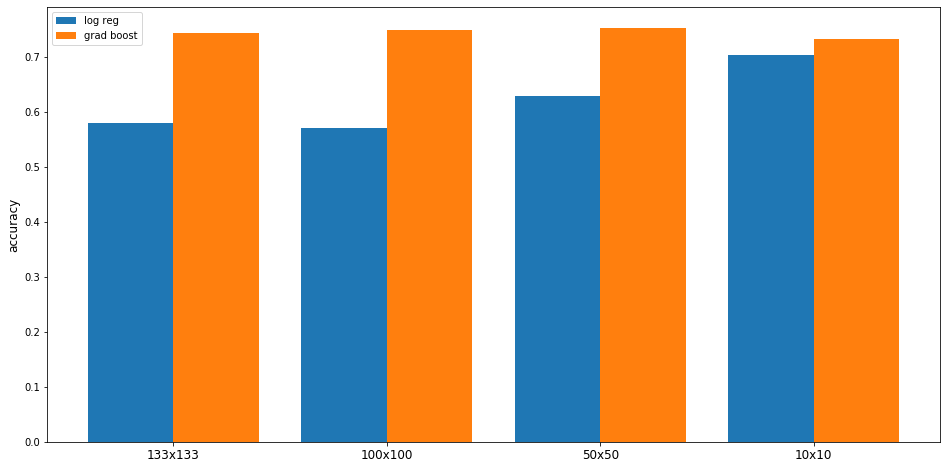

In [35]:
fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, accuracies_logs, width, label='log reg')
rects2 = ax.bar(x + width/2, accuracies_gbcs, width, label='grad boost')

ax.set_ylabel('accuracy', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend();

For a baseline gradient boosting classifier, the accuracy is mostly stable over the sizes, only the 10x10 image shows a slight loss in accuracy. Again, the runtime improves a lot by downsizing the images.

The analysis did not give clear enough results to base a decision on it.

Following we are going to use 50x50 images to ensure a feasable runtime.

One possible reason for the unsuccessfull analysis is, that these models have been used with default parameters and are not great in accuracy from the start. Thus another evaluation will follow at the end using optimized models.

## 2.2. Padding, Resizing, RGB to Greyscale Images

This function is used to convert RGB images into greyscale images. Therefore the source folder with the colored images and the target folder will be specified, where the greyscale images will be saved.

In [11]:
# convert rgb to greyscale images
def rgb_to_grey(img_path, source_folder, target_folder):
    
    # create target folder, if not exist
    if not os.path.exists(os.path.join(img_path,target_folder)):
        os.makedirs(os.path.join(img_path,target_folder))
    
    # get all filenames
    filenames = [os.path.basename(x) for x in glob.glob(os.path.join(img_dir,source_folder,'*.png'))]
    
    # load images 
    for fn in filenames:
        img = Image.open(os.path.join(img_path,source_folder,fn))          
        # to greyscale
        img = img.convert('L')
        img.save(os.path.join(img_path,target_folder,fn))
        
    print('convert rgb images to greyscale finished')

To provide images with same width and height, each image will be resized and the missing pixels will be filled with black color. The image will be centered in the middle. A very convenient padding and resizing function is offered by PILLOW.

In [12]:
# resize images to eg. size 50x50 and insert black border if needed
def pad(img_path, source_folder, target_folder, max_size=50):
    
    # create target folder, if not exist
    if not os.path.exists(os.path.join(img_path,target_folder)):
        os.makedirs(os.path.join(img_path,target_folder))
    
    # get all filenames
    filenames = [os.path.basename(x) for x in glob.glob(os.path.join(img_dir,source_folder,'*.png'))]
    
    for fn in filenames:
        img = Image.open(os.path.join(img_path,source_folder,fn))  
        # padding
        new_img = ImageOps.pad(img, (max_size,max_size), 
                                      color='black', centering=(0.5, 0.5))
        new_img.save(os.path.join(img_path,target_folder,fn))
        
    print('resize and padding finished')

This will create and save resized, padded and greyscale images.

In [13]:
img_dir = '...\cell_images'
folders = ['Uninfected', 'Parasitized']

# 50x50, padded images in rgb
pad_folders = ['dz50_pad_Uninfected', 'dz50_pad_Parasitized']
pad(img_dir, folders[0], pad_folders[0], max_size=50)
pad(img_dir, folders[1], pad_folders[1], max_size=50)

# 133x133, padded images in rgb
rgb_pad_folders = ['pad_Uninfected', 'pad_Parasitized']
pad(img_dir, folders[0], rgb_pad_folders[0], max_size=133)
pad(img_dir, folders[1], rgb_pad_folders[1], max_size=133)

# 50x50, padded images in bw
bw_pad_folders = ['dz50_pad_bw_Uninfected', 'dz50_pad_bw_Parasitized']
rgb_to_grey(img_dir, pad_folders[0], bw_pad_folders[0])
rgb_to_grey(img_dir, pad_folders[1], bw_pad_folders[1])

resize and padding finished
resize and padding finished
resize and padding finished
resize and padding finished
convert rgb images to greyscale finished
convert rgb images to greyscale finished


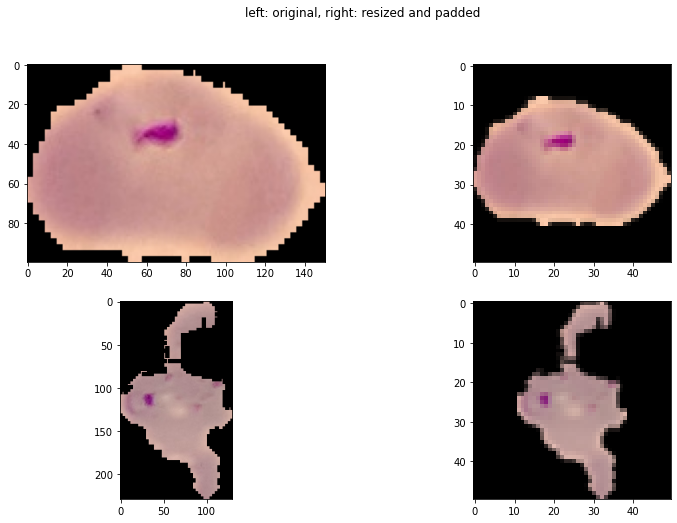

In [14]:
# visualize padded images
fn1 = 'C33P1thinF_IMG_20150619_120645a_cell_216.png'
fn2 = 'C39P4thinF_original_IMG_20150622_105102_cell_86.png'

f, axs = plt.subplots(2,2)
f.suptitle('left: original, right: resized and padded')
axs[0,0].imshow(Image.open(os.path.join(img_dir,folders[1],fn1)))
axs[0,1].imshow(Image.open(os.path.join(img_dir,pad_folders[1],fn1)))
axs[1,0].imshow(Image.open(os.path.join(img_dir,folders[1],fn2)))
axs[1,1].imshow(Image.open(os.path.join(img_dir,pad_folders[1],fn2)))
f.set_size_inches(13,8)
plt.show()

## 2.3. PCA Basics

The PCA (principal component analalysis) provided by sklearn is a linear dimensionality reduction using singular value decomposition to project the input data into a lower feature space. The components are the eigenvectors of the input data's covariance matrix, therefore a decomposition technique is used. The effect of the color channels of the RGB images will be considered.

In [15]:
from sklearn.decomposition import PCA

img_dir = '...\cell_images'
rgb_pad_folders = ['pad_Uninfected', 'pad_Parasitized']
csv_train = 'train.csv'

# load training data (rgb, padded)
print('load train data')
x_train_r, y_train_r = get_datasets(img_dir, csv_train, rgb_pad_folders)
print('done')

# reshape x_train_r
print('reshape')
x_train_pca = []
for id_xtr in range(len(x_train_r)):
    x_train_pca.append(x_train_r[id_xtr].reshape(-1, 3))
    
# no. of images, 133x133, 3 color channels
x_train_pca = np.array(x_train_pca)
print(np.shape(x_train_pca))

load train data
pad_Uninfected:11023
pad_Parasitized:11023
done
reshape
(22046, 17689, 3)


The PCA will be visualized for 3 components for each color channel.

In [16]:
# show PCA for 3 components
n_components = 3

x_transformed = np.zeros((len(x_train_pca),n_components,3))
print('fit transform pca')
for channel in range(3):
    pca = PCA(n_components)
    pca.fit(x_train_pca[:,:,channel])
    x_transformed[:,:,channel] = pca.transform(x_train_pca[:,:,channel])
    
print('done')

fit transform pca
done


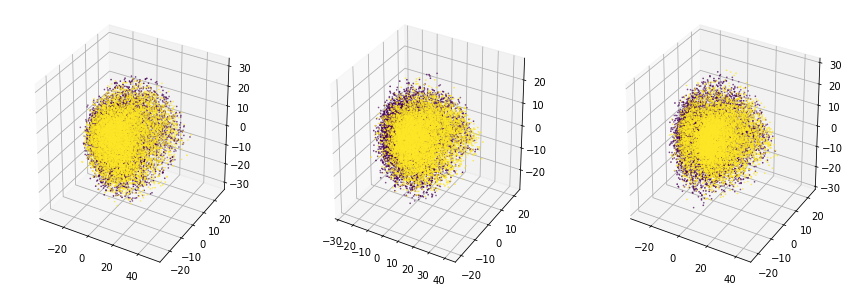

In [7]:
from mpl_toolkits.mplot3d import axes3d

color_channels = 3

f = plt.figure()
#for each channel plot for 3 components each
ax = f.add_subplot(1, 3, 1, projection='3d')
ax.scatter(x_transformed[:,0,0], x_transformed[:,1,0], x_transformed[:,2,0], c=y_train_r, s=0.5)
ax = f.add_subplot(1, 3, 2, projection='3d')
ax.scatter(x_transformed[:,0,1], x_transformed[:,1,1], x_transformed[:,2,1], c=y_train_r, s=0.5)
ax = f.add_subplot(1, 3, 3, projection='3d')
ax.scatter(x_transformed[:,0,2], x_transformed[:,1,2], x_transformed[:,2,2], c=y_train_r, s=0.5)
f.set_size_inches(15,5)
plt.show()

The distribution of the projected input data into the 3 component spaces shows, that the PCA with higher components are needed to be provided for a high-performance classification model. In the above images, the PCA is shown for (from left to right) red, green and blue color channel of the images.

In [31]:
# lets see for higher components
n_components = 1000 #n_components = 0.95

x_transformed = np.zeros((len(x_train_pca),n_components,3))
print('fit transform pca')
for channel in range(3):
    pca = PCA(n_components)
    pca.fit(x_train_pca[:,:,channel])
    x_transformed[:,:,channel] = pca.transform(x_train_pca[:,:,channel])
    
print('done')

fit transform pca
done


A backtransformation of the PCA is provided by:

In [15]:
# back transform for reconstruction
x_inv_transf = np.zeros((len(x_transformed),133,133,3), 'uint8')
channels = 3
for idx_ch in range(channels):
    x_inv_transf[..., idx_ch] = 255.*pca.inverse_transform(x_transformed[:,:,idx_ch]).reshape(len(x_transformed),133, 133) 
    
print(np.shape(x_inv_transf))

(17636, 133, 133, 3)


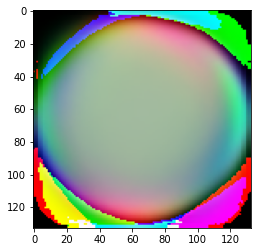

In [17]:
# visualize reconstructed images
plt.imshow(Image.fromarray(x_inv_transf[1],'RGB'))
plt.show()

A better representation of the eigenvalues are given by the following explained variance plot. The amount of variance of each the selected components is visualized.

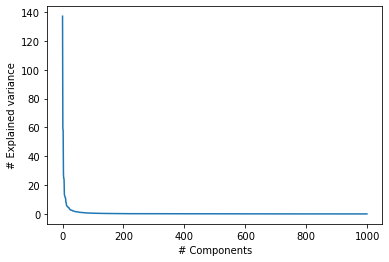

In [32]:
plt.plot(pca.explained_variance_)
plt.xlabel("# Components")
plt.ylabel("# Explained variance")
plt.show()

A way better plot is the ratio of the explained variance to get the percentage of variance explained by each of the selected components.

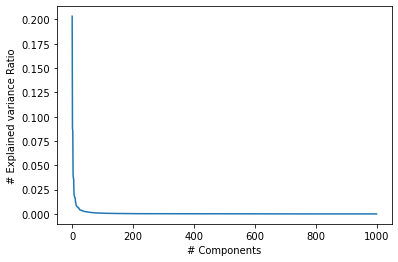

In [33]:
# how much each component contributes to variance in percentage
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("# Components")
plt.ylabel("# Explained variance Ratio")
plt.show()

But the real deal is the accummulated ratio of the variance explained by each the component. Here, it is shown that for ~300 components ~90 % of the feature is represented by the PCA and 95.39 % by 1000 components described by the explained variance. In this case, sklearn implement the n_component parameter to be able to take percentages.

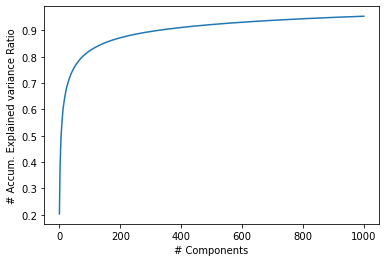

In [34]:
# in total percentage
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("# Components")
plt.ylabel("# Accum. Explained variance Ratio")
plt.show()

In [35]:
print(np.max(pca.explained_variance_ratio_.cumsum()))

0.9538746759346767


## 2.4 Flattening

Since all models except the neuronal network expect two dimensional arrays, the datasets have to be flattend.

In [ ]:
# First a trainings and test set need to be loaded.
img_dir = '.../cell_images'
folders = ['dz50_pad_bw_Uninfected', 'dz50_pad_bw_Parasitized']
csv_files = ['train.csv', 'test.csv']

print('train data')
x_train, y_train = get_datasets(img_dir, csv_files[0])
print('test data')
x_test, y_test = get_datasets(img_dir, csv_files[1])

In [ ]:
# Reshape to a 2 dimensiomal array:
x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = np.array(y_train)
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = np.array(y_test)

## 2.5. PCA Feature Reduction

To reduce the runtime for all models a feature reduction is warranted. This will be achieved by performing a principal components analysis. 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# n_components=0.95 to ensure that a major portion of the information is still
# in the transformed dataset while using considerably fewer features
pca = PCA(n_components=0.95, random_state=0)
pca.fit(x_train)

In [ ]:
x_train = pca.transform(x_train)

In [ ]:
x_test = pca.transform(x_test)

# 3. Machine Learning Models

For each model, a cross-validation is done to search for the best hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## 3.1. Logistic Regression
Logistic regression is a linear model for classification.
This model was chosen for its efficiency to train and fast classification of unknown records.
For this model a cross validation was done over the inverse of regularization strength C.
Smaller values of C specify stronger regularization.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#The inverse of regularization strength range search:
param_grid = {"C": np.logspace(-6, 10, num=9, base=2.0)}

# Grid search:
log_reg = LogisticRegression(max_iter=1000)
log_reg_valid = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring="accuracy")

#Training:
log_reg_valid.fit(x_train, y_train)

In [ ]:
#Gives the best parameters after the training:
log_reg_valid.best_params_

The best inverse of regularization strength is:

C = 0.015625

### Evaluation

In [ ]:
# Prediction:
y_pred_log_reg = log_reg_valid.predict(x_test)

In [ ]:
# Accuracy:
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
accuracy_log_reg

The accuracy for the logistic regression is 0.6621915820029027.

In [ ]:
# Confusion matrix:
confusion_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg, labels=[0, 1])
confusion_matrix_log_reg

Result: 

array([[1847, 909],
      [ 953, 1803]], dtype=int64)


In [ ]:
# The precision is the ability of the classifier not to label as positive 
# a sample that is negative.
# The best value is 1 and the worst value is 0:
precision_log_reg = precision_score(y_test, y_pred_log_reg)
precision_log_reg

The precision for the logistic regression is 0.6648230088495575.

In [ ]:
# The recall is the ability of the classifier to find all the positive samples.
#The best value is 1 and the worst value is 0:
recall_log_reg = recall_score(y_test, y_pred_log_reg)
recall_log_reg

The recall for the logistic regression is 0.6542089985486212.

## 3.2. Random Forest Classifier
The random forest classifier is a collection of prediction trees, where every tree is dependent on random vectors sampled independently.
This model was chosen because it can handle large data sets due to its capability to work with many variables.
For this model a cross validation was done over the number of trees in the forest (n_estimators) and the maximum depth of the tree (max_depth).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Maximum depth of the tree  and number of trees in the forest range search:
param_grid = {"max_depth": np.arange(1, 9),
             "n_estimators": 100*np.arange(1,9)}

# Gird search:
forest = RandomForestClassifier()
forest_valid = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring="accuracy")

# Training:
forest_valid.fit(x_train, y_train)

In [ ]:
#Gives the best parameters after the training:
forest_valid.best_params_

The maximum depth of the tree is 8.

The number of trees in the forest are 600.

### Evaluation

In [ ]:
# Prediction:
y_pred_rf = forest_valid.predict(x_test)

In [ ]:
# Accuracy:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_rf

The accuracy for the random forest classifier is 0.6801523947750363.

In [ ]:
# Confusion matrix:
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
confusion_matrix_rf

Result:

array([[1737, 1019], [ 744, 2012]], dtype=int64


In [ ]:
# The precision is the ability of the classifier not to label as positive 
# a sample that is negative.
# The best value is 1 and the worst value is 0:
precision_rf = precision_score(y_test, y_pred_rf)
precision_rf

The precision for the random forest classifier is 0.6638073243154075.

In [ ]:
# The recall is the ability of the classifier to find all the positive samples.
# The best value is 1 and the worst value is 0:
recall_rf = recall_score(y_test, y_pred_rf)
recall_rf

The recall for the random forest classifier is 0.7300435413642961.

## 3.3. Gradient Boosting Classifier
The Gradient Boosting model was chosen for often providing a good accuracy.

For this model, a Randomized Search Cross Validation was done to optimize the hyperparameters. The following parameters were searched:
the number of boosting stages (n_estimators), the fraction of samples to be used for fitting the individual base learners (subsample), the maximum depth of the individual regression estimators (max_depth) and the learning rate (and learning_rate).

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.fixes import loguniform

In [ ]:
# Parameter range search:
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': np.arange(1, 6),
    'learning_rate': loguniform(1e-2, 1e0),
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

# Random grid search:
gbc_opt = RandomizedSearchCV(
    GradientBoostingClassifier(),
    param_distributions=param_distributions,
    n_iter=50,
    n_jobs=-1,
    scoring="accuracy"
)

# Training:
gbc_opt.fit(x_train, y_train)

In [ ]:
# The optimized hyperparameters are:
gbc_opt.best_params_

The learning rate is 0.2115323333933389;

The fraction of samples to be used for fitting the individual base learners is 0.8.

The maximum depth of the individual regression estimators is 5;

The number of boosting stages to perform is 1000;

Note: It shows that two of the hyperparameters have their optimium at the limit values. This is a strong indication that the gradient boosting classifier should be further optimized with different ranges for the hyperparameters.

### Evaluation

In [ ]:
# Prediction:
y_pred_gbc = gbc_opt.predict(x_test)

In [ ]:
# Accuracy:
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
accuracy_gbc

The accuracy for the gradient boosting is 0.7304063860667634.

In [ ]:
# Confusion matrix:
confusion_matrix_gbc = confusion_matrix(y_test, y_pred_gbc, labels=[0, 1])
confusion_matrix_gbc

Result:

array([[1993, 763], [ 723, 2033]], dtype=int64)


In [ ]:
# Precision: 
precision_gbc = precision_score(y_test, y_pred_gbc)
precision_gbc

The precision for the gradient boosting is 0.727110157367668.

In [ ]:
# Recall: 
recall_gbc = recall_score(y_test, y_pred_gbc)
recall_gbc

The recall for the gradient boosting is 0.7376632801161103.

## 3.4. Support Vector Machines

Support Vector Machine model was chosen for investigational reasons, only to compare the model efficiency to other models trained above.
We could conclude that this model is not ideal for this type of dataset.
Even, doing all the data preprocessing, the code took 22 houres to run all dataset, and had to be stopped. So, for this model we ran the code with a smaller data set, with 3000 training and 600 test points.

### Get small dataset

In [8]:
def get_small_datasets(img_path, csvfile, number=100):
    
    
    n = int(number/2)
    x = []
    y = []
   
    # read csv table
    data = pd.read_csv(csvfile, header=None)
    # sort data by labels to separate infected from uninfected to ensure an even split
    data.sort_values(by=1)
    # extract a specified number of values from each class
    data0 = data.iloc[:n, :]
    data1 = data.iloc[-n:, :]
    data = data0.append(data1)
    # shuffle the classes
    data = data.sample(frac=1).reset_index(drop=True)
    
    # get filename and label
    filenames = data.iloc[:, 0].tolist()
    labels = data.iloc[:, 1].tolist()
    
    # load images with conversion to b/w
    for fn,lb in zip(filenames,labels):
        img = Image.open(os.path.join(img_path,folders[lb],fn))
        img = np.array(img) / 255.
        x.append(img)
        y.append(lb)
      
    print(folders[0]+':'+str(y.count(0)))
    print(folders[1]+':'+str(y.count(1)))
    return x, y

In [9]:
print('train data')
x_train_s, y_train_s = get_small_datasets(img_dir, csv_files[0], number=3000)
print('test data')
x_test_s, y_test_s = get_small_datasets(img_dir, csv_files[1], number=600)


train data
dz50_pad_bw_Uninfected:1500
dz50_pad_bw_Parasitized:1500
test data
dz50_pad_bw_Uninfected:300
dz50_pad_bw_Parasitized:300


In [10]:
# Reshape to a 2 dimensiomal array:
x_train_s = np.array(x_train_s)
x_train_s = x_train_s.reshape(x_train_s.shape[0], -1)
y_train_s = np.array(y_train_s)

x_test_s = np.array(x_test_s)
x_test_s = x_test_s.reshape(x_test_s.shape[0], -1)
y_test_s = np.array(y_test_s)

In [11]:
x_train_s = pca.transform(x_train_s)
x_test_s = pca.transform(x_test_s)

### Optimization of hyperparameters

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [15]:
param_grid = {"C": np.logspace(-6, 10, num=9, base=2.0),
             "kernel": ["linear","rbf"]}
       
svm = SVC()
svm_valid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring="accuracy")
svm_valid.fit(x_train_s, y_train_s)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.5625e-02, 6.2500e-02, 2.5000e-01, 1.0000e+00, 4.0000e+00,
       1.6000e+01, 6.4000e+01, 2.5600e+02, 1.0240e+03]),
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [16]:
# The optimized hyperparameters are:
svm_valid.best_params_

{'C': 1.0, 'kernel': 'rbf'}

Result:

{'C': 1.0, 'kernel': 'rbf'

### Train optimized SVM on full dataset

In [17]:
svm_opt = SVC(C=svm_valid.best_params_['C'], kernel=svm_valid.best_params_['kernel'])
svm_opt.fit(x_train, y_train)

SVC()

### Evaluation

In [18]:
y_pred_svm = svm_opt.predict(x_test)

In [19]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_svm

0.7021044992743106

Result:

0.7021044992743106

In [20]:
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm, labels=[0, 1])
confusion_matrix_svm

array([[1906,  850],
       [ 792, 1964]], dtype=int64)

Result:

[[1906,  850],[ 792, 1964]]

In [21]:
precision_svm = precision_score(y_test, y_pred_svm)
precision_svm

0.6979388770433547

Result:

0.6979388770433547

In [22]:
recall_svm = recall_score(y_test, y_pred_svm)
recall_svm

0.7126269956458636

Result:

0.7126269956458636

## 3.5.  Convolutional Neural Network

The convolutional neural network is a deep learning approach for most commonly used in images. This neural network takes advantages of the sparcial convoltion, shared-weight architecture and connected neurons in a way that the network will learn the right filters automatically, by backpropagation. Although the training of the CNN can be very computational expensive, it shows an impressive performance in terms of related object classicifation. The repetition in iterating over the training data (epochs) updates the weights in the filter kernel with the help of an optimizing method. Here the Stochastic Gradient Descent shows the best results. A learning parameter for the backpropagation is used. At the end of the net, a flattening of the data is streamed to a fully connected layer and activation for classification. The avoidance of the overfitting is provided by a dropout and pooling layer. It is also possible to reduce the model by regulizers.
<br>
Here, we will investigate a two (and one) covlutional layer model to the malaria dataset. The image size is reduced to 50x50 px and the difference between colored and greyscale images in CNNs are tested. The impact of the learning parameter of the optimizer is also examined. The following code is used for the CNN composition.

In [ ]:
import glob
import os
import pandas as pd
from PIL import Image, ImageOps
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# load training, testing and validation data
def get_datasets(img_path, csvfile, folders):
    
    x = []
    y = []
    
    # read csv table, get filename and label
    data = pd.read_csv(csvfile, header=None)
    filenames = data.iloc[:, 0].tolist()
    labels = data.iloc[:, 1].tolist()
    
    #
    for fn,lb in zip(filenames,labels):
        img = Image.open(os.path.join(img_path,folders[lb],fn))          
        img = np.array(img) / 255. 
        # numpy HxWxC to Torch CxHxW
        img = img[None, :, :] # for rgb replace with: img = np.transpose(img,(2,0,1))
        x.append(img)
        y.append(lb)
        
    
    print(folders[0]+':'+str(y.count(0)))
    print(folders[1]+':'+str(y.count(1)))
    
    return x, y


def train_test_load(img_dir, folders, csv_train, csv_test):
    
    # load images and labels describes in csv tables
    x_train, y_train = get_datasets(img_dir, csv_train, folders)
    x_test, y_test = get_datasets(img_dir, csv_test, folders)

    # convert to torch
    x_train = torch.from_numpy(np.array(x_train)).float()
    y_train = torch.from_numpy(np.array(y_train)).long()
    x_test = torch.from_numpy(np.array(x_test)).float()
    y_test = torch.from_numpy(np.array(y_test)).long()

    # torch data set
    trainset = TensorDataset(x_train, y_train)
    testet = TensorDataset(x_test, y_test)

    # training and testing loader
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = DataLoader(testet, batch_size=1000, shuffle=False)
    
    # check torch dimension
    print('training set')
    print(x_train.shape)
    print(y_train.shape)

    # check torch dimension
    print('testing set')
    print(x_test.shape)
    print(y_test.shape)
    
    return trainloader, testloader


# CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # for rgb images choose: nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        # if layer2 is dropped: choose self.fc1 = nn.Linear(25 * 25 * 32, 32)
        self.fc1 = nn.Linear(12 * 12 * 64, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    
def cnn_train_test(trainloader, testloader, conv_net, criterion, optimizer): 
    # training of cnn model
    l = []
    e = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = conv_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                #print('[%d, %5d] loss: %.3f' %
                #      (epoch + 1, i + 1, running_loss / 100))
                e.append(epoch + 1)
                l.append(running_loss / 100)
                running_loss = 0.0

    print('Finished Training')

    # plot loss over epochs
    plt.plot(range(1,epochs+1,1),l[::6])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()


    # training accuracy metrices
    correct = 0
    total = 0
    classes = ('Uninfected', 'Parasitized')
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = conv_net(images)
            _, predicted = torch.max(outputs, 1)

            # total accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # accuracy on classes
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    print('Train Accuracy : ')
    print(float(correct)/float(total))

    
    for i in range(nb_classes):
        print('Train Accuracy of %5s : ' % (classes[i]))
        print(float(class_correct[i]) / float(class_total[i]))


    # testing  accuracy metrices
    correct = 0
    total = 0
    classes = ('Uninfected', 'Parasitized')
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    confusion_matrix_cnn_bw = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = conv_net(images)
            _, predicted = torch.max(outputs, 1)

            # accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # accuracy on classes
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            # confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                    confusion_matrix_cnn_bw[t.long(), p.long()] += 1


    accuracy_cnn_bw = float(correct) / float(total)      
    print('Test Accuracy : ')
    print(accuracy_cnn_bw)            

    for i in range(nb_classes):
        print('Test Accuracy of %5s : ' % (classes[i]))
        print(float(class_correct[i]) / float(class_total[i])) 

    print('Confusion Matrix : ')
    confusion_matrix_cnn_bw = confusion_matrix_cnn_bw.numpy()
    print(confusion_matrix_cnn_bw)


    tp = confusion_matrix_cnn_bw[1,1]
    fp = confusion_matrix_cnn_bw[0,1]
    fn = confusion_matrix_cnn_bw[1,0]
    precision_cnn_bw=tp/(tp+fp)
    print('Precision : '+str(precision_cnn_bw))

    recall_cnn_bw = tp/(tp+fn)
    print('Recall : '+str(recall_cnn_bw))

dz50_pad_bw_Uninfected:11023
dz50_pad_bw_Parasitized:11023
dz50_pad_bw_Uninfected:2756
dz50_pad_bw_Parasitized:2756
training set
torch.Size([22046, 1, 50, 50])
torch.Size([22046])
testing set
torch.Size([5512, 1, 50, 50])
torch.Size([5512])
[1,   100] loss: 0.691
[1,   200] loss: 0.687
[1,   300] loss: 0.684
[1,   400] loss: 0.678
[1,   500] loss: 0.677
[1,   600] loss: 0.676
[2,   100] loss: 0.674
[2,   200] loss: 0.656
[2,   300] loss: 0.648
[2,   400] loss: 0.651
[2,   500] loss: 0.650
[2,   600] loss: 0.661
[3,   100] loss: 0.637
[3,   200] loss: 0.631
[3,   300] loss: 0.629
[3,   400] loss: 0.627
[3,   500] loss: 0.622
[3,   600] loss: 0.626
[4,   100] loss: 0.607
[4,   200] loss: 0.612
[4,   300] loss: 0.615
[4,   400] loss: 0.606
[4,   500] loss: 0.602
[4,   600] loss: 0.597
[5,   100] loss: 0.585
[5,   200] loss: 0.592
[5,   300] loss: 0.585
[5,   400] loss: 0.582
[5,   500] loss: 0.571
[5,   600] loss: 0.551
[6,   100] loss: 0.547
[6,   200] loss: 0.551
[6,   300] loss: 0.523


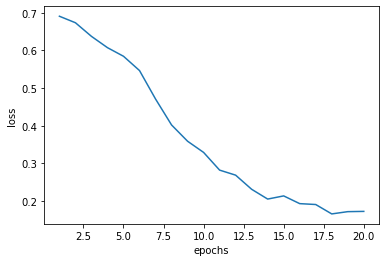

Accuracy of the network on train images: 93 %
Accuracy of Uninfected : 95 %
Accuracy of Parasitized : 90 %
Accuracy of the network on test images: 93 %
Accuracy of Uninfected : 100 %
Accuracy of Parasitized : 83 %
confusion matrix:
[[2628.  128.]
 [ 233. 2523.]]
precision:0.9517163
recall:0.9154572


In [7]:
# folder directories
img_dir = '...\cell_images'
pad_folders = ['dz50_pad_bw_Uninfected', 'dz50_pad_bw_Parasitized']
# pad_folders = ['dz50_pad_Uninfected', 'dz50_pad_Parasitized'] for rgb images
csv_train = 'train.csv'
csv_test = 'test.csv'
epochs = 20
nb_classes = 2

# load training and testing stream
trainloader, testloader = train_test_load(img_dir, pad_folders, csv_train, csv_test)
    
# create cnn model    
conv_net = ConvNet()

# optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(conv_net.parameters(), lr=0.01)
optimizer = optim.SGD(conv_net.parameters(), lr=0.001, momentum=0.9)

# cnn training and testing
cnn_train_test(trainloader, testloader, conv_net, criterion, optimizer)

![cnn_tests](cnn_tests.png)

RGB images are overall better classified as greyscale images. The convergence for sgd learning rate 0.01 (bw) and 0.001 (rgb) is a lot steeper.
For a higher sgd learning rate of 0.1 (bw) the cnn doesn‘t classify at all


With Learning Rate 0.01:

![good](cnn_bw_2layer_sgd001.png)

With Learning Rate: 0.1

![bad](cnn_bw_2layer_sgd01.png)

RGB Images:

![color](cnn_rgb_2layer_sgd0001.png)

# 4. Evaluation


Here we are going to compare the performances of our models with the help of four different metrics

## 4.1 Accuracy

The accuracy score returns the fraction of correct predictions.

It is calcualated as:

$$
accuracy (y,\hat{y})   =  1/N  \sum_{i=1}^N (\hat{y}_i = y_i), 
$$
$$
with N = len(y)
$$


In [134]:
import matplotlib.pyplot as plt
import numpy as np

In [163]:
labels = ['logistic regression', 'random forest', 'gradient boost', 'support vector machine', 'neuronal network']

In [164]:
x = np.arange(len(labels))

In [165]:
ys = [accuracy_log_reg, accuracy_rf, accuracy_gbc, accuracy_svm, accuracy_cnn_bw]

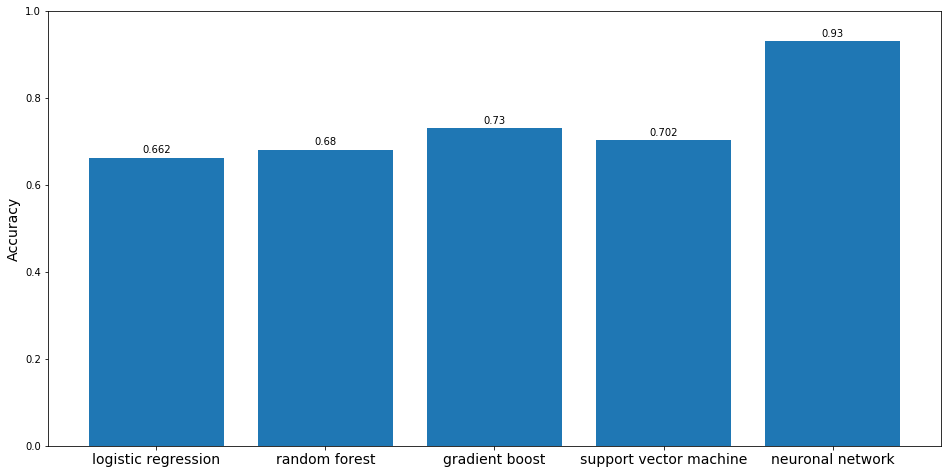

In [166]:
fig, ax = plt.subplots(figsize=(16,8))
rect = ax.bar(x, ys)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)

def label(rects):
    """Attach a text label above each bar, displaying its height."""
    for rect in rects: 
        height = np.round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


label(rect)


## 4.2 Confusion Matrix

The confusion matrix gives the values for the true negatives (c_m[0,0]), false negatives (c_m[1,0]), true positives  (c_m[1,1]) and false positives (c_m[0,1]).

In [168]:
matrices = [confusion_matrix_log_reg, confusion_matrix_rf, confusion_matrix_gbc, confusion_matrix_svm, confusion_matrix_cnn_bw]

In [169]:
tn = [m[0,0] for m in matrices]
fn = [m[1,0] for m in matrices]
tp = [m[1,1] for m in matrices]
fp = [m[0,1] for m in matrices]

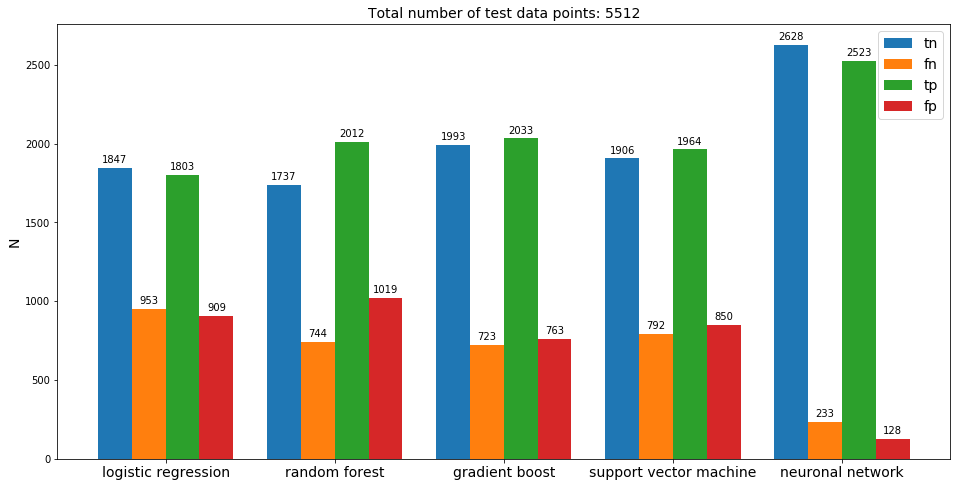

In [170]:
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - 1.5*width, tn, width, label='tn')
rects2 = ax.bar(x - width/2, fn, width, label='fn')
rects3 = ax.bar(x + width/2, tp, width, label='tp')
rects4 = ax.bar(x + 1.5*width, fp, width, label='fp')

ax.set_ylabel('N', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Total number of test data points: 5512', fontsize=14)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

## 4.3 Precision

Precision gives the ratio of true positives to all positive predicted samples (true positive + false positive).

In [172]:
ys = [precision_log_reg, precision_rf, precision_gbc, precision_svm, precision_cnn_bw]

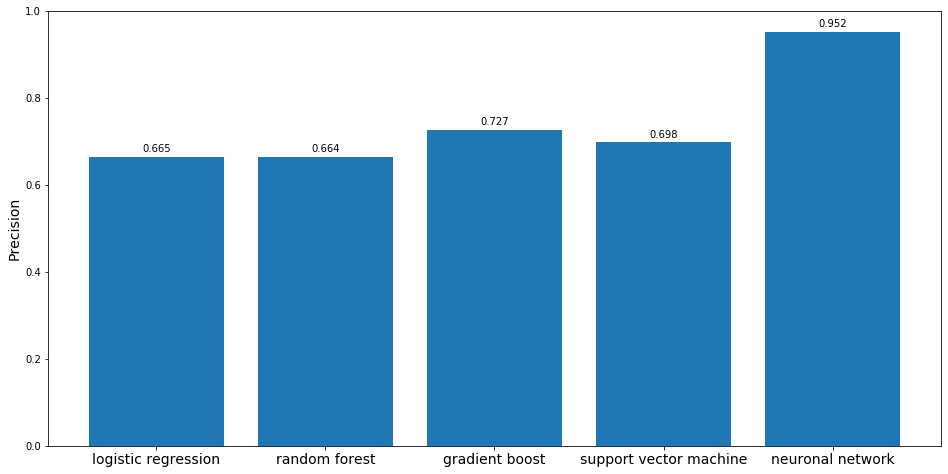

In [173]:
fig, ax = plt.subplots(figsize=(16,8))
rect = ax.bar(x, ys)
ax.set_ylim(0, 1)
ax.set_ylabel('Precision', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
label(rect)

## 4.4 Recall

Recall returns the ratio of true positives to true positives + false negatives.
If it reaches ots max at 1, it indicates the ability of the classifier to find all positive values.
This is especially important in cases like this, when one is trying to classify healthy vs. sick, where it is vitally important to find all infected, and a false negative might have worse consequences than a false positive.

In [175]:
ys = [recall_log_reg, recall_rf, recall_gbc, recall_svm, recall_cnn_bw]

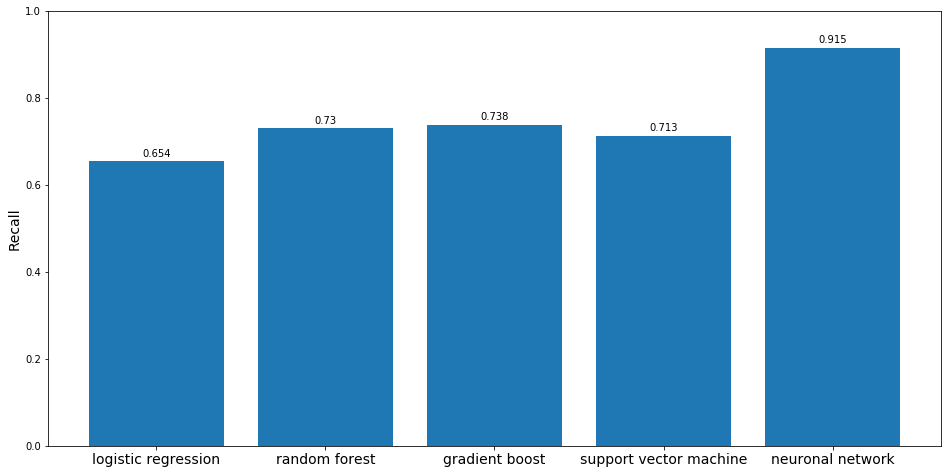

In [176]:
fig, ax = plt.subplots(figsize=(16,8))
rect = ax.bar(x, ys)
ax.set_ylim(0, 1)
ax.set_ylabel('Recall', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
label(rect)

## 4.5. Discussion

Over all used metrics it is apparent that none of the other models in their current state can compete with the convolutional neuronal network. Accuracy, precision, recall and confusion matrix all show a similar trend over the different models. The logistic regression shows the lowest values. Although it is very useful in this case for preliminary analysis due to its very short runtime, it is not accurate enough in its predictions to be used as the only model. 
Random forest and gradient boost show similar results, both of which are not quite good enough for this use case. It should be mentioned though, that further optimizations of the hyperparameters are possible and even neccessary, especially for the gradient boosting classifier. As mentioned before, this model showed best performance at the limit of two of the investigated hyperparameter ranges. A further optimization could still improve its performance.
The support vector machine is currently competetive with the other models in performance, but not in runtime. As explained before, due to its high runtime for large datasets it is not recommended for use in cases like this.
Over all the convolutional neuronal network shows by far the best performance. It is definetly the model of choice in this comparative analysis, not only due to its high performance regarding the metrics, but also because of its relatively low runtime.

## 4.6 Re-evaluation image size

Repetiton of the earlier conducted analysis with optimized models.

In [ ]:
# define image folders
img_dir = '.../cell_images'
folders = ['pad_Uninfected', 'pad_Parasitized']
csv_files = ['train.csv', 'test.csv']


In [ ]:
# load dataset
print('train data')
x_train, y_train = get_small_dataset_var_sizes(img_dir, csv_files[0], [(100, 100), (50, 50), (10, 10)], number=3000)
print('test data')
x_test, y_test = get_small_dataset_var_sizes(img_dir, csv_files[1], [(100, 100), (50, 50), (10, 10)], number=600)

### 4.6.1 Logistic Regression

#### Model: initialization, fit including timer

In [39]:
n = len(x_train)
# initialization of an estimator for each dataset
logs = [LogisticRegression(max_iter=1000, C=0.015625) for i in range(n)]
timing_log_opt = []
# training of an estimator on each dataset variying in image size
for i in range(n):
    start = time.time()
    logs[i].fit(x_train[i], y_train[i])
    stop = time.time()
    duration = stop - start
    timing_log_opt.append(duration)
    print(duration)

26.123182773590088
10.283154010772705
1.6485099792480469
0.01496124267578125


#### Evaluation

In [42]:
# calculates the accuracy for each estimator
accuracies_logs_opt = []
for i in range(n):
    y_pred = logs[i].predict(x_test[i])
    accuracy = accuracy_score(y_test[i], y_pred)
    accuracies_logs_opt.append(accuracy)

In [43]:
for i in range(n):
    print(f'Shape: {x_train[i].shape} Accuracy: {accuracies_logs_opt[i]:.4f} Time: {timing_log_opt[i]:.1f}')

Shape: (3000, 17689) Accuracy: 0.6533 Time: 26.1
Shape: (3000, 10000) Accuracy: 0.6700 Time: 10.3
Shape: (3000, 2500) Accuracy: 0.6883 Time: 1.6
Shape: (3000, 100) Accuracy: 0.6433 Time: 0.0


The optimized logistic regression shows the best accuracy for the 50x50 images, which is not completely surprising, since that is the size it was optimized for. It is worth mentioning though, that the accuracy does not vary much over all image sizes.

### 4.6.2 Gradient Boosting Classifier

#### Model: initialization, fit including timer

In [20]:
n = len(x_train)
# initialization of an estimator for each dataset
gbcs = [GradientBoostingClassifier(learning_rate=0.2115,
                                  max_depth=5,
                                  n_estimators=1000,
                                  subsample=0.8) for i in range(n)]
timing_gbc_opt = []
# training of an estimator on each dataset variying in image size
for i in range(n):
    start = time.time()
    gbcs[i].fit(x_train[i], y_train[i])
    stop = time.time()
    duration = stop - start
    timing_gbc_opt.append(duration)
    print(duration)

4727.525859832764
2143.9277193546295
573.4059846401215
29.743847608566284


#### Evaluation

In [49]:
# calculates the accuracy for each estimator
accuracies_gbcs_opt = []
for i in range(n):
    y_pred = gbcs[i].predict(x_test[i])
    accuracy = accuracy_score(y_test[i], y_pred)
    accuracies_gbcs_opt.append(accuracy)

In [51]:
for i in range(n):
    print(f'Shape: {x_train[i].shape} Accuracy: {accuracies_gbcs_opt[i]:.4f} Time: {timing_gbc_opt[i]:.1f}')

Shape: (3000, 17689) Accuracy: 0.7667 Time: 4727.5
Shape: (3000, 10000) Accuracy: 0.7867 Time: 2143.9
Shape: (3000, 2500) Accuracy: 0.7650 Time: 573.4
Shape: (3000, 100) Accuracy: 0.7567 Time: 29.7


The optimized gradient boosting classifier shows the highest accuracy for the 100x100 images. Again, the variation is not very large.

### 4.6.3 Visualization

In [66]:
labels = ['133x133', '100x100', '50x50', '10x10']
x = np.arange(len(labels))

In [64]:
width = 0.4  # the width of the bars

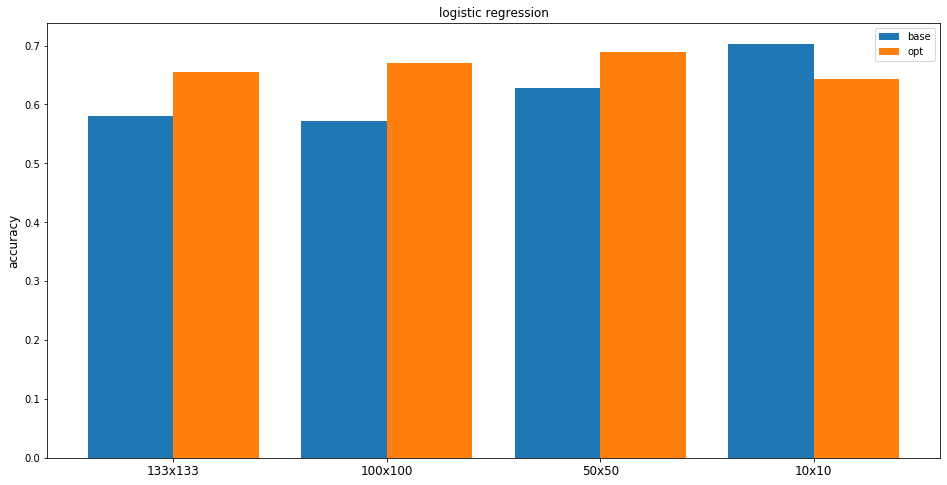

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, accuracies_logs, width, label='base')
rects2 = ax.bar(x + width/2, accuracies_logs_opt, width, label='opt')

ax.set_ylabel('accuracy', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()
ax.set_title('logistic regression', fontsize=12);

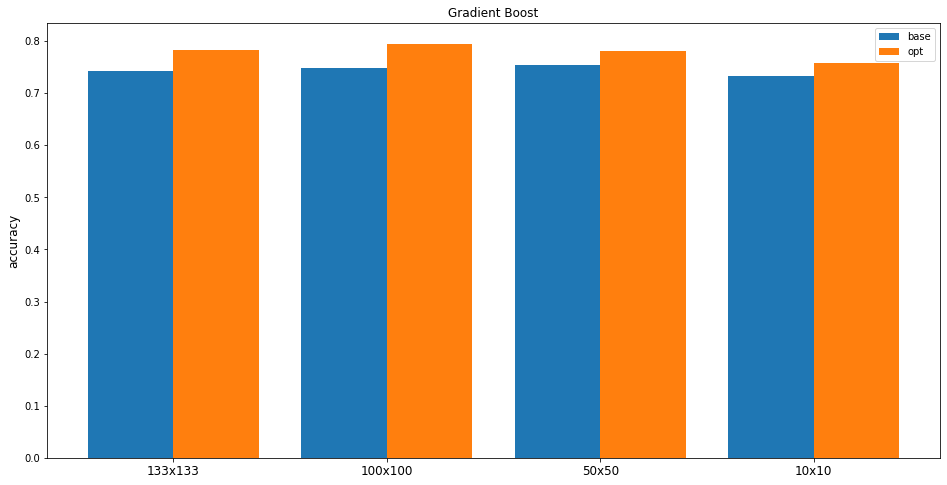

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, accuracies_gbcs, width, label='base')
rects2 = ax.bar(x + width/2, accuracies_gbcs_opt, width, label='opt')

ax.set_ylabel('accuracy', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()
ax.set_title('Gradient Boost', fontsize=12);

The graphs show that the performance for these models is not mainly dependent on the image sizes. Although one needs to consider that the optimized models are not much better than the baseline ones. It goes to show how difficult it is to actually optimize a machine learning model.